In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Задание 1.

In [2]:
data = pd.read_csv('winequality-red.csv')
y = data['quality']
X = data.drop('quality', axis=1)

In [3]:
y.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [4]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, roc_auc_score, make_scorer

precision = make_scorer(precision_score, average='macro', zero_division=0)
recall = make_scorer(recall_score, average='macro', zero_division=0)

In [5]:
from sklearn.model_selection import train_test_split
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=35)
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size=0.25, stratify=y_tv, random_state=35)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
param_grid = {'n_neighbors': np.arange(1, 10), 
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
             'weights': ['uniform', 'distance']}
neigh_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='roc_auc_ovr').fit(X_tv.values, y_tv.values)
neigh_grid.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}

In [8]:
param_grid = {'max_depth': np.arange(1, 10),
             'criterion': ['gini', 'entropy'],
             'splitter': ['best', 'random']}
decision_grid = GridSearchCV(DecisionTreeClassifier(random_state=35), param_grid, cv=5, scoring='roc_auc_ovr').fit(X_tv, y_tv)
decision_grid.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}

In [9]:
param_grid = {'penalty': ['l1', 'l2'],
             'tol': np.arange(1e-5, 1e-4, 1e-5)}
logit_grid = GridSearchCV(LogisticRegression(random_state=35, solver='liblinear', max_iter=500), param_grid, cv=5, scoring='roc_auc_ovr').fit(X_tv, y_tv)
logit_grid.best_params_

{'penalty': 'l1', 'tol': 1e-05}

In [10]:
neigh = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='distance')
decision = DecisionTreeClassifier(criterion='entropy', max_depth=5, splitter='random', random_state=35)
logit = LogisticRegression(solver='liblinear', max_iter=500, random_state=35, penalty='l1', tol=1e-5)

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

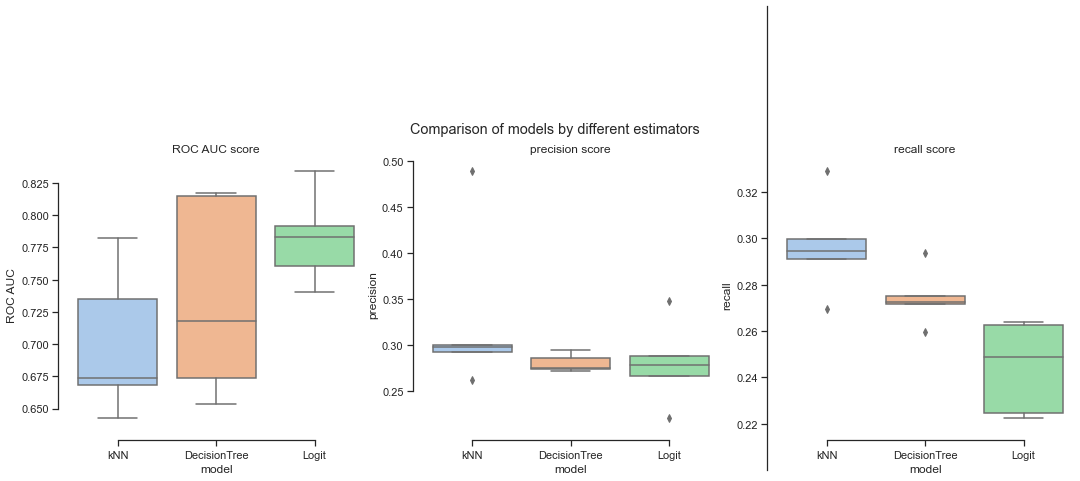

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle('Comparison of models by different estimators')

scores = ['ROC AUC', 'precision', 'recall']
for index, scoring in enumerate(['roc_auc_ovr', precision, recall]):    
    neigh_cv = cross_val_score(neigh, X_tv.values, y_tv.values, cv=5, scoring=scoring)
    decision_cv = cross_val_score(decision, X_tv, y_tv, cv=5, scoring=scoring)
    logit_cv = cross_val_score(logit, X_tv, y_tv, cv=5, scoring=scoring)
    
    data = pd.DataFrame([neigh_cv, decision_cv, logit_cv]).T
    data.columns = ['kNN', 'DecisionTree', 'Logit']
    
    axes[index].set_title(scores[index] + ' score')
    sns.boxplot(ax=axes[index], data=data)
    sns.despine(offset=10, trim=True)
    axes[index].set_xlabel('model')
    axes[index].set_yscale('linear')
    axes[index].set_ylabel(scores[index])

plt.show()

In [13]:
from sklearn.preprocessing import OneHotEncoder
sparse = OneHotEncoder().fit_transform(y_test.to_numpy().reshape(-1, 1))
onehot_tv = pd.DataFrame.sparse.from_spmatrix(sparse).astype(int)

neigh_auc = roc_auc_score(onehot_tv.to_numpy(), neigh.fit(X_train.values, y_train.values).predict_proba(X_test.values), multi_class='ovr')
decision_auc = roc_auc_score(onehot_tv.to_numpy(), decision.fit(X_train, y_train).predict_proba(X_test), multi_class='ovr')
logit_auc = roc_auc_score(onehot_tv.to_numpy(), logit.fit(X_train, y_train).predict_proba(X_test), multi_class='ovr')

print('The ROC AUC on the test are as follows:\nkNN:\t\t{:.6}\nDecTree:\t{:.6}\nLogit:\t\t{:.6}'.format(neigh_auc, decision_auc, logit_auc))

The ROC AUC on the test are as follows:
kNN:		0.612556
DecTree:	0.712891
Logit:		0.786917


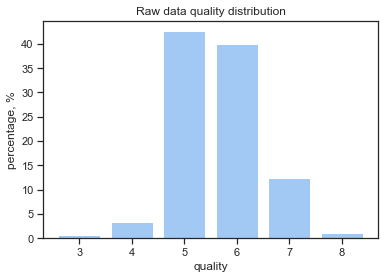

In [14]:
fig, ax = plt.subplots()
plt.title("Raw data quality distribution")
plt.bar(x=y.unique(), height=y.value_counts() / y.value_counts().sum() * 100)
ax.set_xlabel('quality')
ax.set_ylabel('percentage, %')
plt.show()

In [15]:
precision = make_scorer(precision_score, zero_division=0)
recall = make_scorer(recall_score, zero_division=0)

def test(model, target):
    prec = cross_val_score(model, X.values, target.values, cv=5, scoring=precision)
    rec = cross_val_score(model, X.values, target.values, cv=5, scoring=recall)
    roc_auc = cross_val_score(model, X.values, target.values, cv=5, scoring='roc_auc')
    return np.array([prec.mean(), rec.mean(), roc_auc.mean()])

arrays = [np.array([3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8]), 
          np.array(['kNN', 'DecTree', 'Logit', 'kNN', 'DecTree', 'Logit', 'kNN', 'DecTree', 'Logit',
                    'kNN', 'DecTree', 'Logit', 'kNN', 'DecTree', 'Logit', 'kNN', 'DecTree', 'Logit'])]

result = pd.DataFrame(columns=['precision', 'recall', 'roc_auc'], index=arrays)
for quality in y.unique():
    flags = (y == quality).astype(int)
    neigh = KNeighborsClassifier()
    decision = DecisionTreeClassifier(random_state=35)
    logit = LogisticRegression(solver='liblinear', random_state=35)
    result.loc[(quality, 'kNN')] = test(neigh, flags)
    result.loc[(quality, 'DecTree')] = test(decision, flags)
    result.loc[(quality, 'Logit')] = test(logit, flags)

result

precision    recall   roc_auc
3 kNN           0.0       0.0   0.53458
  DecTree  0.033333       0.1  0.541819
  Logit         0.0       0.0  0.797441
4 kNN           0.0       0.0  0.472286
  DecTree  0.093961  0.194545  0.567838
  Logit         0.0       0.0  0.718393
5 kNN      0.516756  0.488697  0.619588
  DecTree  0.575354  0.588632  0.631389
  Logit    0.683904  0.635573  0.793337
6 kNN      0.408004  0.402719  0.515009
  DecTree  0.456438  0.468639  0.548037
  Logit    0.545593   0.26298  0.627988
7 kNN      0.380561  0.190769  0.700047
  DecTree  0.334812  0.331282   0.60957
  Logit    0.509398  0.155256  0.853626
8 kNN           0.0       0.0  0.580703
  DecTree  0.040385       0.1  0.541141
  Logit         0.0       0.0  0.865692

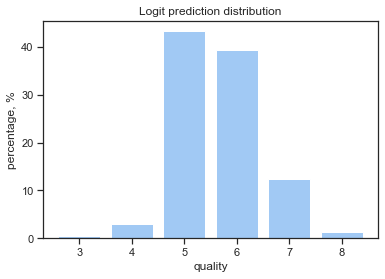

In [17]:
logit.fit(X_tv, y_tv)
prediction = logit.predict_proba(X_test)
fig, ax = plt.subplots()
plt.title("Logit prediction distribution")
plt.bar(x=logit.classes_, height=prediction.sum(axis=0) / prediction.sum() * 100)
ax.set_xlabel('quality')
ax.set_ylabel('percentage, %')
plt.show()

In [18]:
decision = DecisionTreeClassifier(criterion='entropy', max_depth=5, splitter='random', random_state=35).fit(X_train, y_train)
importance = pd.Series(decision.feature_importances_, index=X_train.columns).sort_values(ascending=False)

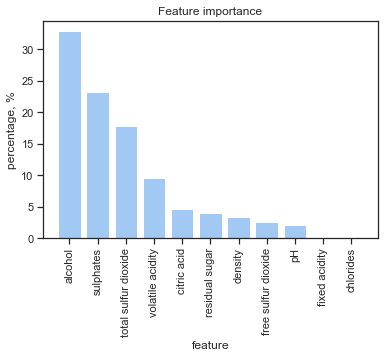

In [19]:
fig, ax = plt.subplots()
plt.title("Feature importance")
plt.bar(x=importance.index, height=importance * 100)
plt.xticks(rotation=90)
ax.set_xlabel('feature')
ax.set_ylabel('percentage, %')
plt.show()

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

st_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

neigh = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='distance')
logit = LogisticRegression(solver='liblinear', max_iter=500, random_state=35, penalty='l1', tol=1e-5)

neigh_cv = cross_val_score(neigh, X_tv.values, y_tv.values, cv=5, scoring='roc_auc_ovr')
logit_cv = cross_val_score(logit, X_tv, y_tv, cv=5, scoring='roc_auc_ovr')

neigh_cv_st = cross_val_score(neigh, st_scaler.fit_transform(X_tv), y_tv.values, cv=5, scoring='roc_auc_ovr')
logit_cv_st = cross_val_score(logit, st_scaler.transform(X_tv), y_tv, cv=5, scoring='roc_auc_ovr')

neigh_cv_mm = cross_val_score(neigh, mm_scaler.fit_transform(X_tv), y_tv.values, cv=5, scoring='roc_auc_ovr')
logit_cv_mm = cross_val_score(logit, mm_scaler.transform(X_tv), y_tv, cv=5, scoring='roc_auc_ovr')

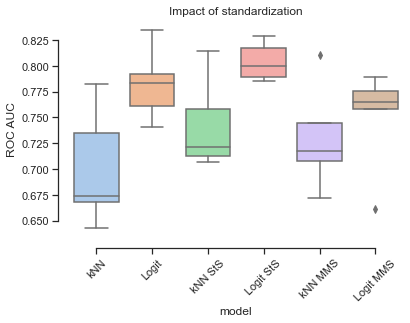

In [21]:
data = pd.DataFrame([neigh_cv, logit_cv, neigh_cv_st, logit_cv_st, neigh_cv_mm, logit_cv_mm]).T
data.columns = ['kNN', 'Logit', 'kNN StS', 'Logit StS', 'kNN MMS', 'Logit MMS']

fig, ax = plt.subplots()
plt.title('Impact of standardization')
sns.boxplot(data=data)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=45)
ax.set_xlabel('model')
ax.set_ylabel('ROC AUC')
plt.show()

# Задание 2.

In [22]:
y = (y > 6.5).astype(int)
y.value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [23]:
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=35)
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size=0.25, stratify=y_tv, random_state=35)

In [24]:
param_grid = {'n_neighbors': np.arange(1, 10), 
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
             'weights': ['uniform', 'distance']}
neigh_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='roc_auc_ovr').fit(X_tv.values, y_tv.values)
neigh_grid.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}

In [25]:
param_grid = {'max_depth': np.arange(1, 10),
             'criterion': ['gini', 'entropy'],
             'splitter': ['best', 'random']}
decision_grid = GridSearchCV(DecisionTreeClassifier(random_state=35), param_grid, cv=5, scoring='roc_auc_ovr').fit(X_tv, y_tv)
decision_grid.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'splitter': 'best'}

In [26]:
param_grid = {'penalty': ['l1', 'l2'],
             'tol': np.arange(1e-5, 1e-4, 1e-5)}
logit_grid = GridSearchCV(LogisticRegression(random_state=35, solver='liblinear', max_iter=500), param_grid, cv=5, scoring='roc_auc_ovr').fit(X_tv, y_tv)
logit_grid.best_params_

{'penalty': 'l1', 'tol': 8e-05}

In [27]:
neigh = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='distance')
decision = DecisionTreeClassifier(criterion='entropy', max_depth=4, splitter='best', random_state=35)
logit = LogisticRegression(solver='liblinear', max_iter=500, random_state=35, penalty='l1', tol=8e-5)

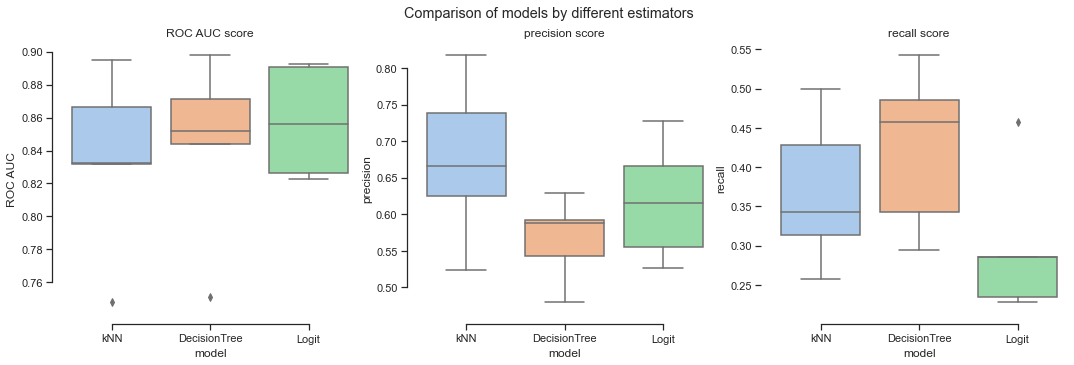

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle('Comparison of models by different estimators')

scores = ['ROC AUC', 'precision', 'recall']
for index, scoring in enumerate(['roc_auc', precision, recall]):    
    neigh_cv = cross_val_score(neigh, X_tv.values, y_tv.values, cv=5, scoring=scoring)
    decision_cv = cross_val_score(decision, X_tv.values, y_tv.values, cv=5, scoring=scoring)
    logit_cv = cross_val_score(logit, X_tv.values, y_tv.values, cv=5, scoring=scoring)
    
    data = pd.DataFrame([neigh_cv, decision_cv, logit_cv]).T
    data.columns = ['kNN', 'DecisionTree', 'Logit']
    
    axes[index].set_title(scores[index] + ' score')
    sns.boxplot(ax=axes[index], data=data)
    sns.despine(offset=10, trim=True)
    axes[index].set_xlabel('model')
    axes[index].set_yscale('linear')
    axes[index].set_ylabel(scores[index])

plt.show()

In [29]:
neigh_auc = roc_auc_score(y_test, neigh.fit(X_train.values, y_train.values).predict_proba(X_test.values)[:, 1])
decision_auc = roc_auc_score(y_test, decision.fit(X_train, y_train).predict_proba(X_test)[:, 1])
logit_auc = roc_auc_score(y_test, logit.fit(X_train, y_train).predict_proba(X_test)[:, 1])

print('The ROC AUC on the test are as follows:\nkNN:\t\t{:.6}\nDecTree:\t{:.6}\nLogit:\t\t{:.6}'.format(neigh_auc, decision_auc, logit_auc))

The ROC AUC on the test are as follows:
kNN:		0.81706
DecTree:	0.838511
Logit:		0.902443


In [30]:
decision.fit(X_train, y_train)
importance = pd.Series(decision.feature_importances_, index=X_train.columns).sort_values(ascending=False)

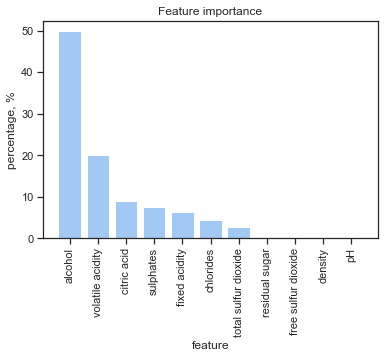

In [31]:
fig, ax = plt.subplots()
plt.title("Feature importance")
plt.bar(x=importance.index, height=importance * 100)
plt.xticks(rotation=90)
ax.set_xlabel('feature')
ax.set_ylabel('percentage, %')
plt.show()

In [32]:
st_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

neigh = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='distance')
logit = LogisticRegression(solver='liblinear', max_iter=500, random_state=35, penalty='l1', tol=1e-5)

neigh_cv = cross_val_score(neigh, X_tv.values, y_tv.values, cv=5, scoring='roc_auc_ovr')
logit_cv = cross_val_score(logit, X_tv, y_tv, cv=5, scoring='roc_auc_ovr')

neigh_cv_st = cross_val_score(neigh, st_scaler.fit_transform(X_tv), y_tv.values, cv=5, scoring='roc_auc_ovr')
logit_cv_st = cross_val_score(logit, st_scaler.transform(X_tv), y_tv, cv=5, scoring='roc_auc_ovr')

neigh_cv_mm = cross_val_score(neigh, mm_scaler.fit_transform(X_tv), y_tv.values, cv=5, scoring='roc_auc_ovr')
logit_cv_mm = cross_val_score(logit, mm_scaler.transform(X_tv), y_tv, cv=5, scoring='roc_auc_ovr')

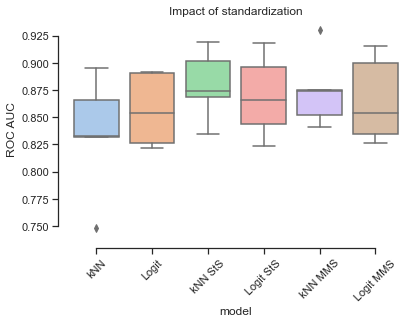

In [33]:
data = pd.DataFrame([neigh_cv, logit_cv, neigh_cv_st, logit_cv_st, neigh_cv_mm, logit_cv_mm]).T
data.columns = ['kNN', 'Logit', 'kNN StS', 'Logit StS', 'kNN MMS', 'Logit MMS']

fig, ax = plt.subplots()
plt.title('Impact of standardization')
sns.boxplot(data=data)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=45)
ax.set_xlabel('model')
ax.set_ylabel('ROC AUC')
plt.show()